## Binary logistic regression

Written by Jess Breda June 2023

In [1]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

Steps
-----
1. generate the dataset
2. Define cost & gradient fx
3. Initialize weights & run optimization
4. Visualize

In [20]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))


# -- PLOT FUNCTIONS -- #
def generate_sigmoids(true_W, optimized_W):
    # create a matrix X with bias column to pass
    # to the sigmoid function
    x_range = np.linspace(-10, 10, 100)
    n_features = len(true_W) - 1
    X_with_bias = np.tile(x_range, (n_features, 1)).T
    X_with_bias = np.c_[np.ones_like(x_range), X_with_bias]  # add bias column

    true_logits = X_with_bias @ true_W
    true_probabilities = sigmoid(true_logits)

    optimized_logits = X_with_bias @ optimized_W
    optimized_probabilities = sigmoid(optimized_logits)

    return x_range, true_probabilities, optimized_probabilities


def plot_sigmoids(x_range, true_probabilities, optimized_probabilities):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(x_range, true_probabilities, label="true", color="gray")
    ax.plot(
        x_range,
        optimized_probabilities,
        label="optimized",
        color="gray",
        linestyle="--",
    )
    ax.legend()
    ax.set(title="Sigmoid Functions", xlabel="Logits", ylabel="Probability")


def plot_weights(true_W, optimized_W):
    fig, ax = plt.subplots(figsize=(6, 4))

    feature_and_bias_labels = np.arange(len(true_W))

    ax.plot(feature_and_bias_labels, true_W, label="true", color="gray", marker="o")
    ax.plot(
        feature_and_bias_labels,
        optimized_W,
        label="optimized",
        color="gray",
        marker="o",
        linestyle="dashed",
    )

    # Set the x-axis tick labels
    _ = ax.set_xticks(feature_and_bias_labels)
    ax.set(xlabel="Feature", ylabel="Weight", title="Recovered Weights")
    ax.legend()

### 1. Generate Data

In [50]:
N = 100000  # Number of samples
D = 2  # Number of features

# Generate random feature values
# X = np.random.randn(N, D)  ## convert to Normal
X = np.random.normal(size=(N, D))

# Generate random true weights (including the bias coefficient)
true_W = np.random.rand(D + 1)
# true_W = np.random.normal(loc=0, scale=1, size=(D + 1))

# Add bias column to the dataset
X_with_bias = np.c_[np.ones(N), X]

# Generate target labels using logistic function
logits = X_with_bias @ true_W
probabilities = sigmoid(logits)
y = np.random.binomial(1, probabilities)

### 2. Define cost & gradient functions

These are passed into scipys' `minimize` function. Note `X` includes a first bias column of 1s.

$$ \text{{logits}} = X \cdot W $$

1. Logistic Regression Cost Function:

$$ \text{{nll}} = \frac{1}{n} \sum_{i=1} ^{n}(y \cdot \log(\text{logits}) - \log(1 + \exp(\text{logits})))$$

$$ \text{{nll}} = \frac{1}{n} \sum_{i=1} ^{n}(y \cdot \log(\text{a}) - \log(1 + \exp(\text{a})))$$

2. Logistic Regression Gradient Function:

$$p(y) = 1 - \frac{1}{1 + \exp(\text{logits})}$$

$$\nabla \text{nll}_W = \frac{{X^T \cdot (\text{{p(y)}} - y)}}{N}$$


3. Logistic Regression Hessian Function:

$$ \text{Hess} = \frac{1}{n} \sum_{i=1} ^{n} (p(y_i) (1 - p(y_i)) x_i x_i^T )

In [51]:
def logistic_regression_cost(w, X, y, sigma=None):
    """
    Compute the negative log-likelihood for binary
    logistic regression with L2 regularization (or MAP).

    params
    ------
    w : weights
    X : data (with bias column)
    Y : target labels, not used but keeping scipy minimize happy
    sigma : float (defualt: None)
        Standard deviation of Gaussian prior, if None
        no regularization is applied.

    returns
    -------
    nll : float
        (regularized) negative log-likelihood
    """
    logits = X @ w

    if sigma:
        penalty = (1 / (2 * sigma**2)) * np.sum(w**2)
    else:
        penalty = 0

    nll = -np.sum((y * logits) - np.logaddexp(0, logits)) - penalty
    return nll


def logistic_regression_gradient(w, X, y, sigma=None):
    """
    Gradient of the cost function for logistic regression using negative log-likelihood

    w: weights
    X : data (with bias column)
    y : target labels (0,1)
    """
    logits = X @ w
    probabilities = sigmoid(logits)

    if sigma:
        penalty_gradient = w / sigma**2
        penalty_gradient[0] = 0  # No penalty for bias
    else:
        penalty_gradient = 0

    gradient = -X.T @ (y - probabilities) + penalty_gradient
    return gradient


def compute_logistic_regression_hessian(W, X, y):
    """
    Hessian matrix of the cost function for logistic regression using negative log-likelihood.

    W : weights
    X : data (with bias column)
    y : target labels (0,1)

    NOTE: needs to be checked
    """
    logits = X @ W
    probabilities = 1 - 1 / (1 + np.exp(logits))
    # Outer product for each data point's feature vector and summing them up
    hessian = sum(
        [(prob * (1 - prob) * np.outer(xi, xi)) for xi, prob in zip(X, probabilities)]
    )
    return hessian / len(y)  # Average over all data points

### 3. Initialize Weights & Optimize

L-BFGS-B versus L-BFGS versus BFGS.

**BFGS:** is a quasi-newton method used for optimization that avoids the costly computation of the Hessian. It approximates the inverse Hessian via gradient updates.

**L-BFGS**: is the limited-memory version of BFGS, doesn't store the full Hessian matrix (or inverse), but instead a subset of vectors that represent this matrix

**L-BFGS-B**: is limited memory version + "bounds". You can implemented bound constraints on the variables being optimized to help minimized the search space. If this is implemented without the `bounds` argument, it is the same as L-BFGS.

In [52]:
initial_W = np.zeros(D + 1)  # Initial guess for weights

# optimize using L-BFGS-B algorithm
result = minimize(
    logistic_regression_cost,
    initial_W,
    args=(X_with_bias, y, 1),
    method="BFGS",
    jac=logistic_regression_gradient,
    options={"disp": True},
)
optimized_W = result.x

Optimization terminated successfully.
         Current function value: 58083.325278
         Iterations: 9
         Function evaluations: 18
         Gradient evaluations: 18


In [53]:
# summarize the result
print("Status : %s" % result["message"])
print("Total Evaluations: %d" % result["nfev"])

print("True weights:", true_W)
print("Optimized weights:", optimized_W)

Status : Optimization terminated successfully.
Total Evaluations: 18
True weights: [0.74403627 0.79653611 0.16034453]
Optimized weights: [0.74665464 0.79276886 0.1665026 ]


In [54]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 58083.32527759516
        x: [ 7.467e-01  7.928e-01  1.665e-01]
      nit: 9
      jac: [ 8.815e-06 -4.396e-06 -2.770e-06]
 hess_inv: [[ 5.240e-05  1.293e-05  2.982e-06]
            [ 1.293e-05  6.357e-05  3.128e-06]
            [ 2.982e-06  3.128e-06  4.945e-05]]
     nfev: 18
     njev: 18

### 5. Visualize the results

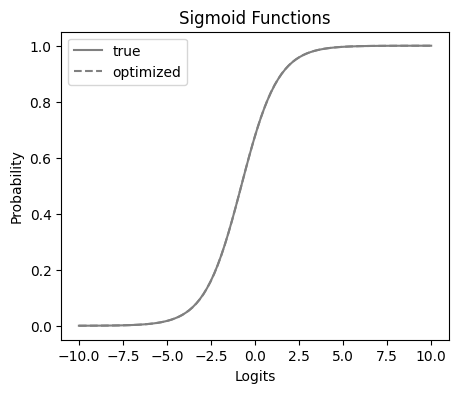

In [55]:
x_range, true_sig, optimized_sig = generate_sigmoids(true_W, optimized_W)
plot_sigmoids(x_range, true_sig, optimized_sig)

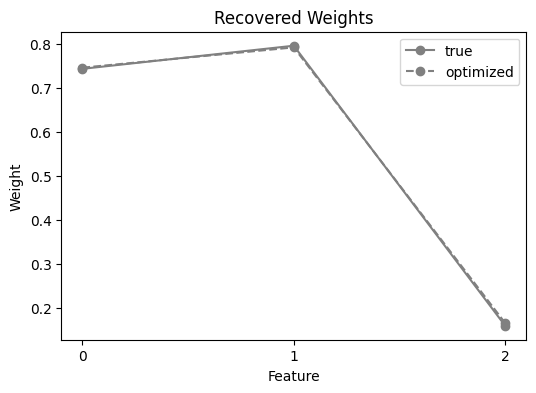

In [56]:
plot_weights(true_W, optimized_W)

## Validation of MAP $\sigma$

In [62]:
N = 10000  # Number of samples
D = 45  # Number of features

# Generate random feature values
X = np.random.normal(size=(N, D))
X_with_bias = np.c_[np.ones(N), X]  # bias column


# Generate random true weights given true sigma (including the bias coefficient)
true_sigma = 2
true_w = np.random.normal(loc=0, scale=true_sigma, size=D + 1)

# Generate target labels using logistic function
logits = X_with_bias @ true_w
probabilities = sigmoid(logits)
y = np.random.binomial(1, probabilities)

print(f"Generated {N} samples with {D} features")
print(f"w is {true_W.shape} \nX is {X_with_bias.shape} \ny is {y.shape}")

print(
    f"w has mean {np.mean(true_w):.3f} and std {np.std(true_w):.3f} with set sigma of {true_sigma}"
)

Generated 10000 samples with 45 features
w is (3,) 
X is (10000, 46) 
y is (10000,)
w has mean 0.362 and std 1.665 with set sigma of 2


In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_with_bias, y, test_size=0.99, random_state=62
)

print(f"Generated train-test split of sample size {len(X_train)} and {len(X_test)}")

Generated train-test split of sample size 100 and 9900


### 2. Compute test nll over sigmas


In [68]:
# initalize
initial_w_flat = np.zeros(D + 1)
sigmas = np.arange(0.1, 6, 0.1)
test_nlls = []
optimized_w_sigma = []
mses = []

# iterate over sigmas, find optimal W, and compute test NLL
for sigma in sigmas:
    result = minimize(
        fun=logistic_regression_cost,
        x0=initial_w_flat,
        args=(X_train, y_train, sigma),
        method="BFGS",
        jac=logistic_regression_gradient,
        options={"disp": True},
    )

    optimized_w = result.x

    # store out
    optimized_w_sigma.append(np.std(optimized_w))
    test_nlls.append(logistic_regression_cost(optimized_w, X_test, y_test, sigma=None))
    mses.append(np.mean((optimized_w - true_w) ** 2))

         Current function value: 37.502247
         Iterations: 4
         Function evaluations: 41
         Gradient evaluations: 30
         Current function value: 15.248963
         Iterations: 3
         Function evaluations: 37
         Gradient evaluations: 26
         Current function value: 16.725954
         Iterations: 6
         Function evaluations: 72
         Gradient evaluations: 60
         Current function value: 10.500961
         Iterations: 35
         Function evaluations: 117
         Gradient evaluations: 105
         Current function value: 7.326604
         Iterations: 29
         Function evaluations: 101
         Gradient evaluations: 89
         Current function value: 5.174805
         Iterations: 29
         Function evaluations: 106
         Gradient evaluations: 94
         Current function value: 3.632718
         Iterations: 27
         Function evaluations: 98
         Gradient evaluations: 86
         Current function value: 2.498923
         Iterat

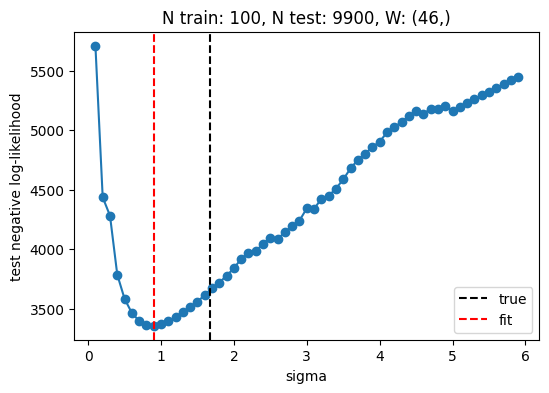

In [69]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sigmas, test_nlls, marker="o")
ax.axvline(x=np.std(true_w), color="k", linestyle="--", label="true")
ax.axvline(x=sigmas[np.argmin(test_nlls)], color="red", linestyle="--", label="fit")

ax.set(
    xlabel="sigma",
    ylabel="test negative log-likelihood",
    title=f"N train: {len(X_train)}, N test: {len(X_test)}, W: {true_w.shape}",
)
ax.legend()

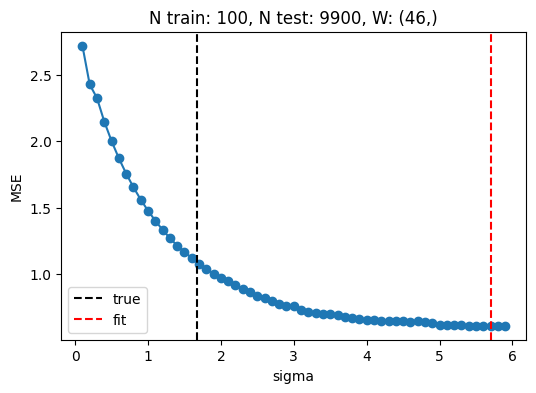

In [70]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sigmas, mses, marker="o")
ax.axvline(x=np.std(true_w), color="k", linestyle="--", label="true")
ax.axvline(x=sigmas[np.argmin(mses)], color="red", linestyle="--", label="fit")

ax.set(
    xlabel="sigma",
    ylabel="MSE",
    title=f"N train: {len(X_train)}, N test: {len(X_test)}, W: {true_w.shape}",
)
ax.legend()

In [71]:
import numpy as np


def gradient_checker(func, grad_func, w, X, y, sigma, epsilon=1e-5):
    """
    Check if the gradient function is correctly computing the gradient of the given function.

    Parameters
    ----------
    func: function
        The function for which the gradient needs to be checked. Should accept w, X, y, sigma.
    grad_func: function
        The gradient function that needs to be checked. Should accept w, X, y, sigma.
    w: ndarray (shape: [D,])
        Initial weights.
    X: ndarray (shape: [N, D])
        Data.
    y: ndarray (shape: [N,])
        Labels.
    sigma: float
        Regularization parameter.
    epsilon: float (default: 1e-5)
        Small perturbation for computing finite differences.

    Returns
    -------
    bool
        True if the gradient function passes the check, False otherwise.
    """
    # Compute the analytic gradient
    analytic_grad = grad_func(w, X, y, sigma)

    # Initialize the numerical gradient
    num_grad = np.zeros_like(w)

    # Compute the numerical gradient
    for i in range(len(w)):
        w1 = w.copy()
        w2 = w.copy()
        w1[i] -= epsilon
        w2[i] += epsilon

        f1 = func(w1, X, y, sigma)
        f2 = func(w2, X, y, sigma)

        num_grad[i] = (f2 - f1) / (2 * epsilon)

    # Compute the relative error between the numerical and analytical gradients
    numerator = np.linalg.norm(analytic_grad - num_grad)
    denominator = np.linalg.norm(analytic_grad) + np.linalg.norm(num_grad)
    relative_error = numerator / denominator

    # If the relative error is small enough, your gradient is correct
    threshold = 1e-7
    if relative_error < threshold:
        print(f"Gradient Check Passed! Relative Error: {relative_error}")
        return True
    else:
        print(f"Gradient Check Failed! Relative Error: {relative_error}")
        return False


# Sample data for testing
np.random.seed(0)
w = np.random.rand(3)
X = np.random.rand(10, 3)
y = np.random.randint(0, 2, 10)
sigma_values = [None, 0.5, 1.0, 2.0]

# Run gradient checker
for sigma in sigma_values:
    print(f"Checking gradient at sigma = {sigma}")
    gradient_checker(
        logistic_regression_cost, logistic_regression_gradient, w, X, y, sigma
    )

Checking gradient at sigma = None
Gradient Check Passed! Relative Error: 1.458514795092436e-11
Checking gradient at sigma = 0.5
Gradient Check Failed! Relative Error: 0.9135675947606019
Checking gradient at sigma = 1.0
Gradient Check Failed! Relative Error: 0.2185876193751393
Checking gradient at sigma = 2.0
Gradient Check Failed! Relative Error: 0.05339856094658217
